In [1]:
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, Variable, ParcelsRandom,   DiffusionUniformKh, AdvectionDiffusionM1, AdvectionDiffusionEM
from datetime import timedelta
import math

In [2]:
# Particle set

class OilParticle(JITParticle):
    """
    This sets up the oil particle with different variables used in the kernels.

    The water fraction is the amount of water in the oil droplets from emulsification, and affects the density and the viscosity.
    The evaporation fraction affects the viscosity of the oil.
    """
    viscosity = Variable('viscosity', dtype=np.float32, initial=0.053)
    density = Variable('density', dtype=np.float32, initial=902)
    original_density = Variable('original_density', dtype=np.float32, initial=902)
    water_fraction = Variable('water_fraction', dtype=np.float32, initial=0)
    evaporation_fraction = Variable('evaporation_fraction', dtype=np.float32, initial=0)
    is_emulsified = Variable('is_emulsified', dtype=np.float32, initial=0)
    emuls_start_time = Variable('emuls_start_time', dtype=np.float32, initial=0)

In [3]:
filedir = '/Users/Gomez023/Postdoc/tutorials/parcels_examples/'

In [4]:
# Field set

fname = filedir + 'GlobCurrent_example_data/*.nc'
filenames = {'U': fname, 'V': fname}
variables = {'U': 'eastward_eulerian_current_velocity', 'V': 'northward_eulerian_current_velocity'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}, # In the GlobCurrent data the dimensions are also called 'lon', 'lat' and 'time'
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

fieldset.add_constant('density_water', 1028)
fieldset.add_constant('viscosity_water', 0.0014)
fieldset.add_constant('g', 9.81)
fieldset.add_constant('wind_threshold', 5)
fieldset.add_constant('wind_speed', 6)
fieldset.add_constant('sea_surface_temperature', 10)
fieldset.add_constant('MixedLayerDepth', 50)

In [5]:
# # Field set WOC

# data_path_v01 = '/data/oceanparcels/input_data/ESA_WorldOceanCirculation/NorthAtlantic/'
# fname_v01 = 'runWOC_NATL_4lb_v1_201109*.nc' #runWOC_NATL_4lb_v1_20110901.nc

# filenames = {'U': data_path_v01 + fname_v01, 'V': data_path_v01 + fname_v01}
# variables = {'U': 'utot', 'V': 'vtot'}
# dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'},
#               'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'}}
# indices = {'depth': [0]} # choosing 00m depth
# fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices)

# fieldset.add_constant('density_water', 1028)
# fieldset.add_constant('viscosity_water', 0.0014)
# fieldset.add_constant('g', 9.81)
# fieldset.add_constant('wind_threshold', 5)
# fieldset.add_constant('wind_speed', 6)
# fieldset.add_constant('sea_surface_temperature', 10)
# fieldset.add_constant('MixedLayerDepth', 50)

In [6]:
# # Field set MOI

# data_path = '/storage/shared/oceanparcels/input_data/MOi/'
# ufiles = sorted(glob(data_path+'psy4v3r1/psy4v3r1-daily_U_*.nc'))
# vfiles = [f.replace('_U_', '_V_') for f in ufiles]
# wfiles = [f.replace('_U_', '_W_') for f in ufiles]
# mesh_mask = data_path + 'domain_ORCA0083-N006/coordinates.nc'

# filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
#              'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
#              'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}
# variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz'}
# dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
#               'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
#               'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

# fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [5]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [8]:
number_particles = 20

lonp = 32 * np.ones(number_particles)
latp = [i for i in np.linspace(-30, -32, number_particles)]

pset = ParticleSet.from_list(fieldset=fieldset, pclass=OilParticle, lon=lonp, lat=latp, depth=np.zeros(number_particles))

# kernels = pset.Kernel(Emulsification) + pset.Kernel(ViscosityChanges) + pset.Kernel(AdvectionRK4)
kernels = pset.Kernel(AdvectionRK4) 

output_file = pset.ParticleFile(name="basic_model_output_ARK4_test01", outputdt=timedelta(seconds=600))

pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(seconds=600), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

INFO: Compiled OilParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/850ef885b38eca68022c7e37ea08137a_0.so


# --> just advection kernel is ok

# Defining the emulsification kernel:

In [6]:
def Emulsification(particle, fieldset, time):
    """
    Process: Emulsification
    
    Breaking waves mixes water into oil droplets. This increases the amount of water in the oil, which increases 
    density as the density of water is higher than the density of oil.
    
    Emulsification does not occur immediately. From OpenDrift for this oil type, the emulsification mostly begins at 
    time steps 9, 10, and 11 (93% of the oil). This kernel then gives the chance of emulsification beginning in these
    time steps as 60.6%, so approximatelt 93% of the oil particles should emulsify in these time steps. After these 
    time steps, there is a small chance per time step (3.5%) of emulsification beginning for the remaining particles.
    
    Once emulsification begins, the water fraction changes based on the equation a + b*x + c*x**2 + d*x**3, with
    x = time in hours (total time of simulation minus the time at which emulsification began for the particle), and
    the coefficients (a, b, c, d) found using an optimizer. The density is then updated using the water fraction, 
    the original oil density, and the density of sea water.
    
    The water fraction cannot go below 0, and cannot exceed 90% (0.9).
    
    """
    if particle.is_emulsified == 0:
        if time == 9*600 or time == 10*600 or time == 11*600:
            if ParcelsRandom.random() < 0.606:
                particle.is_emulsified = 1
                particle.emuls_start_time = time
        elif time > 11*600 and time < 144*600:
            if ParcelsRandom.random() < 0.035:
                particle.is_emulsified = 1
                particle.emuls_start_time = time
        else:
            print('error not emulsified time')
            
    elif particle.is_emulsified == 1:
    
        a = 1.65438927e-02
        b = 7.78843895e-02
        c = -2.51646082e-03
        d = 2.60225731e-05
        x = (time - particle.emuls_start_time)/3600
        particle.water_fraction = a + b * x + c * x**2 + d * x**3
        if particle.water_fraction < 0:
            particle.water_fraction = 0
        elif particle.water_fraction > 0.9:
            particle.water_fraction = 0.9
        else:
            print('error in water frac')
    else:
        print('error in is_emulsified')

    particle.density = particle.water_fraction * fieldset.density_water + (1 - particle.water_fraction) * particle.original_density

In [10]:
number_particles = 20

lonp = 32 * np.ones(number_particles)
latp = [i for i in np.linspace(-30, -32, number_particles)]

pset = ParticleSet.from_list(fieldset=fieldset, pclass=OilParticle, lon=lonp, lat=latp, depth=np.zeros(number_particles))

kernels = pset.Kernel(Emulsification) + pset.Kernel(AdvectionRK4) #+ pset.Kernel(ViscosityChanges)

output_file = pset.ParticleFile(name="basic_model_output_ARK4_and_Emulsification_test01", outputdt=timedelta(seconds=600))

pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(seconds=600), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

INFO: Compiled OilParticleEmulsificationAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/cdb521af9921e9ec226cc1e905de9f09_0.so


# --> works, trying below with the oil_age variable:

# Adding oil age particle equivalent to :
cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
<br>
from : https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_Argofloats.ipynb

In [11]:
# Particle set
"""
This sets up the oil particle with different variables used in the kernels.

The water fraction is the amount of water in the oil droplets from emulsification, and affects the density and the viscosity.
The evaporation fraction affects the viscosity of the oil.
"""

class OilParticle(JITParticle):
    viscosity = Variable('viscosity', dtype=np.float32, initial=0.053)
    density = Variable('density', dtype=np.float32, initial=902)
    original_density = Variable('original_density', dtype=np.float32, initial=902)
    water_fraction = Variable('water_fraction', dtype=np.float32, initial=0)
    evaporation_fraction = Variable('evaporation_fraction', dtype=np.float32, initial=0)
    is_emulsified = Variable('is_emulsified', dtype=np.float32, initial=0)
    emuls_start_time = Variable('emuls_start_time', dtype=np.float32, initial=0)
    oil_age = Variable('oil_age', dtype=np.float32, initial=0.)

In [12]:
def Emulsification(particle, fieldset, time):
    """
    Process: Emulsification
    
    Breaking waves mixes water into oil droplets. This increases the amount of water in the oil, which increases 
    density as the density of water is higher than the density of oil.
    
    Emulsification does not occur immediately. From OpenDrift for this oil type, the emulsification mostly begins at 
    time steps 9, 10, and 11 (93% of the oil). This kernel then gives the chance of emulsification beginning in these
    time steps as 60.6%, so approximatelt 93% of the oil particles should emulsify in these time steps. After these 
    time steps, there is a small chance per time step (3.5%) of emulsification beginning for the remaining particles.
    
    Once emulsification begins, the water fraction changes based on the equation a + b*x + c*x**2 + d*x**3, with
    x = time in hours (total time of simulation minus the time at which emulsification began for the particle), and
    the coefficients (a, b, c, d) found using an optimizer. The density is then updated using the water fraction, 
    the original oil density, and the density of sea water.
    
    The water fraction cannot go below 0, and cannot exceed 90% (0.9).
    
    """
    if particle.is_emulsified == 0:
        # Checking if timestep = 9 or 10 or 11 (*600, which is the particle.dt, could be substituted by that!)
        if particle.oil_age == 9*600 or particle.oil_age == 10*600 or particle.oil_age == 11*600: 
            if ParcelsRandom.random() < 0.606:
                particle.is_emulsified = 1
                particle.emuls_start_time = particle.oil_age
        elif particle.oil_age > 11*600 and particle.oil_age < 144*600:
            if ParcelsRandom.random() < 0.035:
                particle.is_emulsified = 1
                particle.emuls_start_time = particle.oil_age
        else:
            print('error not emulsified time')
            
    elif particle.is_emulsified == 1:
    
        a = 1.65438927e-02
        b = 7.78843895e-02
        c = -2.51646082e-03
        d = 2.60225731e-05
        x = (time - particle.emuls_start_time)/3600
        particle.water_fraction = a + b * x + c * x**2 + d * x**3
        if particle.water_fraction < 0:
            particle.water_fraction = 0
        elif particle.water_fraction > 0.9:
            particle.water_fraction = 0.9
        else:
            print('error in water frac')
    else:
        print('error in is_emulsified')

    particle.density = particle.water_fraction * fieldset.density_water + (1 - particle.water_fraction) * particle.original_density
    
    if particle.state == ErrorCode.Evaluate:
        particle.oil_age += particle.dt  # update oil_age

In [13]:
number_particles = 20

lonp = 32 * np.ones(number_particles)
latp = [i for i in np.linspace(-30, -32, number_particles)]

pset = ParticleSet.from_list(fieldset=fieldset, pclass=OilParticle, lon=lonp, lat=latp, depth=np.zeros(number_particles))

kernels = pset.Kernel(Emulsification) + pset.Kernel(AdvectionRK4) #+ pset.Kernel(ViscosityChanges)

output_file = pset.ParticleFile(name="basic_model_output_ARK4_and_Emulsification_test02", outputdt=timedelta(seconds=600))

pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(seconds=600), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

INFO: Compiled OilParticleEmulsificationAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/cf994081563e5dc954f1d772b928fa56_0.so


# Now checking with the viscosity kernel too:

In [7]:
def ViscosityChanges(particle, fieldset, time):
    """
    Process: Viscosity changes
    
    Viscosity of the oil generally changes due to emulsification and evaporation.
    
    This kernel simulates how viscosity changes over the simulation time. The coefficients (e, f, g, h) were found
    using an optimizer function. y is time in hours.
    
    The limit of the viscosity has been set to 0.001 as a minimum, and 377 as a maximum.
    """
    
    e = 3.07642086e+01 
    f = -1.16058678e+01  
    g = 9.71084673e-01 
    h = -1.19897826e-02
    y = time/3600
    
    particle.viscosity = e + f * y + g * y**2 + h * y**3
    
    if particle.viscosity < 0.001:
        particle.viscosity = 0.001
    elif particle.viscosity > 377:
        particle.viscosity = 377

In [8]:
number_particles = 20

lonp = 32 * np.ones(number_particles)
latp = [i for i in np.linspace(-30, -32, number_particles)]

pset = ParticleSet.from_list(fieldset=fieldset, pclass=OilParticle, lon=lonp, lat=latp, depth=np.zeros(number_particles))

kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(Emulsification) + pset.Kernel(ViscosityChanges)

output_file = pset.ParticleFile(name="basic_model_output_ARK4_and_Emulsification_ViscosityChanges_test01", outputdt=timedelta(seconds=600))

pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(seconds=600), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

INFO: Compiled OilParticleAdvectionRK4EmulsificationViscosityChanges ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/7cec83a526ae0aaca1daf895d00e5fea_0.so


# --> works!

# Checking out the outputs:

## Emulsification kernel outputs:

In [16]:
import xarray as xr

ds_E_01 = xr.open_dataset("basic_model_output_ARK4_and_Emulsification_test01.nc")
ds_E_02 = xr.open_dataset("basic_model_output_ARK4_and_Emulsification_test02.nc")

In [17]:
ds_E_01

<xarray.Dataset>
Dimensions:               (obs: 289, traj: 20)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory            (traj, obs) float64 ...
    time                  (traj, obs) datetime64[ns] ...
    lat                   (traj, obs) float32 ...
    lon                   (traj, obs) float32 ...
    z                     (traj, obs) float32 ...
    viscosity             (traj, obs) float32 ...
    density               (traj, obs) float32 ...
    original_density      (traj, obs) float32 ...
    water_fraction        (traj, obs) float32 ...
    evaporation_fraction  (traj, obs) float32 ...
    is_emulsified         (traj, obs) float32 ...
    emuls_start_time      (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1
    parcels_mesh:           spherical

/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


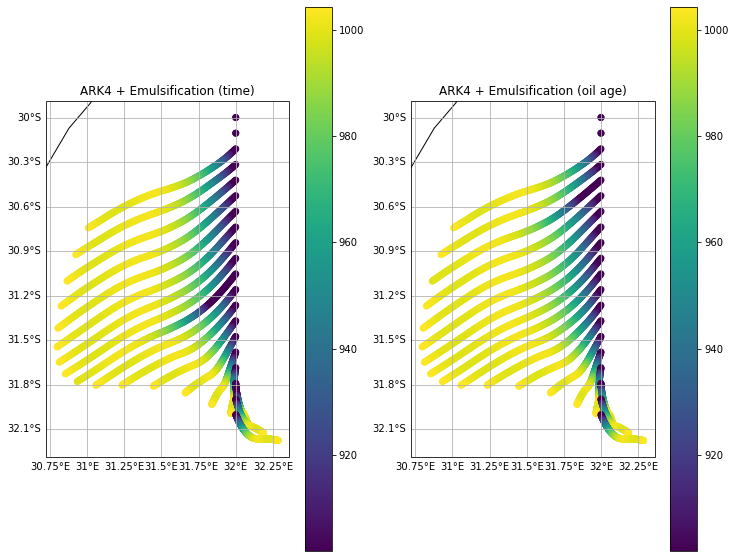

In [18]:
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
cc = ax1.scatter(ds_E_01['lon'], ds_E_01['lat'], c = ds_E_01['density'], transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([4, 10])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_title('ARK4 + Emulsification (time)')
plt.colorbar(cc)

ax1 = plt.subplot(122, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
cc = ax1.scatter(ds_E_02['lon'], ds_E_02['lat'], c = ds_E_02['density'], transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([4, 10])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_title('ARK4 + Emulsification (oil age)')
plt.colorbar(cc)

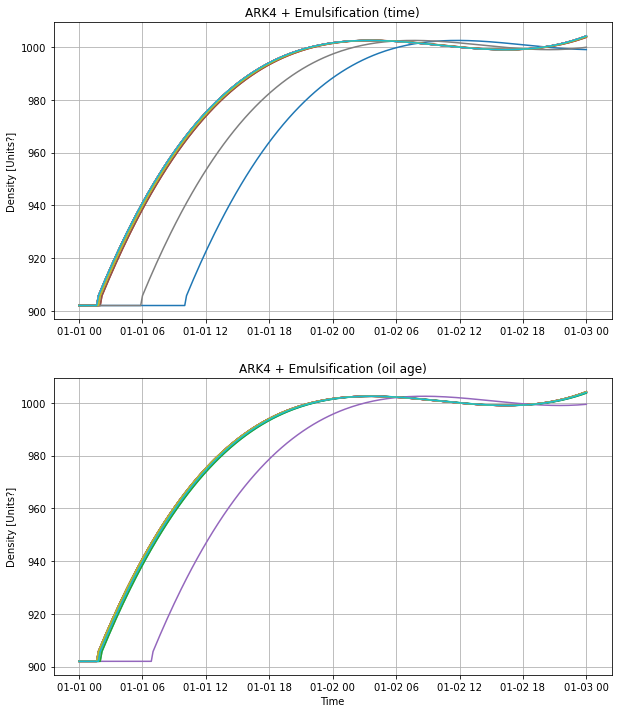

In [19]:
plt.figure(figsize=(10,12))

ax1 = plt.subplot(211)
for i in range(20):
    plt.plot(ds_E_01['time'][i], ds_E_01['density'][i])
ax1.set_title('ARK4 + Emulsification (time)')
ax1.set_ylabel('Density [Units?]')
plt.grid()

ax1 = plt.subplot(212)
for i in range(20):
    plt.plot(ds_E_02['time'][i], ds_E_02['density'][i])
ax1.set_title('ARK4 + Emulsification (oil age)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Density [Units?]')
plt.grid()

plt.show()

# Viscosity simulation:

In [9]:
import xarray as xr

ds_V = xr.open_dataset("basic_model_output_ARK4_and_Emulsification_ViscosityChanges_test01.nc")

In [10]:
ds_V

<xarray.Dataset>
Dimensions:               (obs: 289, traj: 20)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory            (traj, obs) float64 ...
    time                  (traj, obs) datetime64[ns] ...
    lat                   (traj, obs) float32 ...
    lon                   (traj, obs) float32 ...
    z                     (traj, obs) float32 ...
    viscosity             (traj, obs) float32 ...
    density               (traj, obs) float32 ...
    original_density      (traj, obs) float32 ...
    water_fraction        (traj, obs) float32 ...
    evaporation_fraction  (traj, obs) float32 ...
    is_emulsified         (traj, obs) float32 ...
    emuls_start_time      (traj, obs) float32 ...
    oil_age               (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1
    parcels_mesh:           spherical

/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


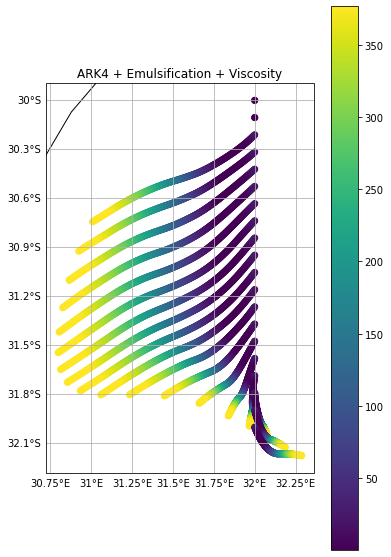

In [12]:
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
cc = ax1.scatter(ds_V['lon'], ds_V['lat'], c = ds_V['viscosity'], transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([4, 10])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_title('ARK4 + Emulsification + Viscosity')
plt.colorbar(cc)


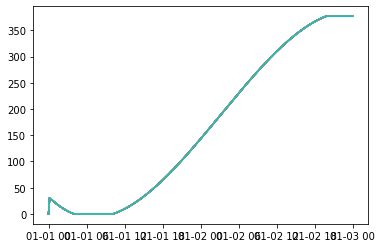

In [13]:
plt.figure()

for i in range(20):
    plt.plot(ds_V['time'][i], ds_V['viscosity'][i])

plt.show()